# Content Based 3d Model Retrieval

###  feedback to be addressed from udacity


The dataset(s) and/or input(s) to be used in the project are thoroughly described. Information such as how the dataset or input is (was) obtained, and the characteristics of the dataset or input, should be included. It should be clear how the dataset(s) or input(s) will be used in the project and whether their use is appropriate given the context of the problem.

Could you briefly discuss the nature of this dataset? How many objects are contained? What is the distribution of labels?

Look at the data. Taken from: http://modelnet.cs.princeton.edu/

This data is in Object File Format (.off) There exist matlab tools to process these. Are they available in python? 

##### off files are ascii

make sure when writing you use
https://stackoverflow.com/questions/46850103/writing-to-files-in-ascii-with-python3-not-utf8

### How are voxels counted? 
http://vision.princeton.edu/projects/2014/3DShapeNets/paper.pdf

```
To study 3D shape representation, we propose to represent
a geometric 3D shape as a probability distribution of
binary variables on a 3D voxel grid. Each 3D mesh is represented
as a binary tensor: 1 indicates the voxel is inside the
mesh surface, and 0 indicates the voxel is outside the mesh
(i.e., it is empty space). The grid size in our experiments is
30 × 30 × 30.
```

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from off_utils import (check_header,
                       parse_vertices_faces_edges,
                       load_off_file,
                       parse_coordinates,
                       parse_face_indeces)

a = load_off_file('sample.off')
coordinates = parse_coordinates(a)
face_indeces = parse_face_indeces(a)

In [2]:
coordinates

array([[-0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5],
       [-0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5],
       [-0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [-0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5]])

#  Resubmit proposal with class imbalances

# Evaluate class balance for ModelNet10 and ModelNet40

finish once ModelNet40 (HUGE) is done downloading

In [8]:
from count_files import make_file_description_data_frame

df = make_file_description_data_frame()

woops!:
['.', 'ModelNet10', '']
woops!:
['.', 'ModelNet10', 'bed']
woops!:
['.', 'ModelNet10', 'chair']
woops!:
['.', 'ModelNet10', 'toilet']


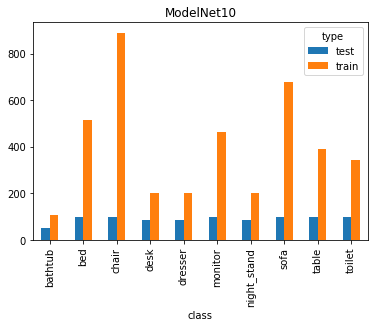

In [44]:
a = df.groupby(['class', 'type'])['type'].count()
a.unstack().plot(kind='bar', title='ModelNet10')

In [43]:
a.unstack()

type,test,train
class,,
bathtub,50,106
bed,100,515
chair,100,889
desk,86,200
dresser,86,200
monitor,100,465
night_stand,86,200
sofa,100,680
table,100,392


In [7]:
a.to_clipboard()

# Visualize *.off point cloud

In [80]:
with open(os.path.join('./ModelNet10/', paths[0]['class'], paths[0]['type'], paths[0]['file']), 'r') as f:
    thing = f.readlines()